<a href="https://colab.research.google.com/github/AndreAmaduzzi/tensorflow-vs-pytorch/blob/main/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification on Tensorflow

## Import dependencies

In [19]:
from __future__ import print_function
from __future__ import division

import copy
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import requests
import os
import time
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from timeit import default_timer as timer
from typing import Callable, Dict, List, Tuple, Union
from torchsummary import summary
from tqdm import tqdm

## Reproducibility and Deterministic Mode

In [2]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=7)

## Building skin cancer dataset

### Load and unzip data
Before running the next code cells, the user must download the Skin Cancer Dataset at [this link](https://https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000) and place it in his Google Drive. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp "/content/drive/My Drive/archive.zip" "archive.zip"

^C


In [5]:
!unzip --qq archive.zip -d data

[archive.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of archive.zip or
        archive.zip.zip, and cannot find archive.zip.ZIP, period.


### Data preparation

In [3]:
root = 'data/'
metadata = pd.read_csv(os.path.join(root, "HAM10000_metadata.csv"))
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
short_to_full_name_dict = {
    "akiec" : "Bowen's disease",
    "bcc" : "basal cell carcinoma" , 
    "bkl" : "benign keratosis-like lesions", 
    "df" : "dermatofibroma", 
    "mel" : "melanoma", 
    "nv" : "melanocytic nevi", 
    "vasc" : "vascular lesions", 
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

#  we add the lesion_name and the label for each image
metadata["label"] = metadata["dx"].map(lesion_ID_dict)
metadata["lesion_name"] = metadata["dx"].map(short_to_full_name_dict)

In [5]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,lesion_name
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,benign keratosis-like lesions


### Build tree directory, compatible with tf.keras.utils.image_dataset_from_directory



In [6]:
labels = metadata["lesion_name"].unique()
print(labels)
ds_folder = os.path.join(root, 'dataset')
os.mkdir(ds_folder)

['benign keratosis-like lesions' 'melanocytic nevi' 'dermatofibroma'
 'melanoma' 'vascular lesions' 'basal cell carcinoma' "Bowen's disease"]


FileExistsError: ignored

In [7]:
for label in labels:
  os.mkdir(os.path.join(ds_folder, str(label)))

FileExistsError: ignored

In [8]:
ext_images = 'jpg'

images_1 = sorted([str(path) for path in Path(os.path.join(root, 'HAM10000_images_part_1')).rglob(f"*.{ext_images}")])
images_2 = sorted([str(path) for path in Path(os.path.join(root, 'HAM10000_images_part_2')).rglob(f"*.{ext_images}")])
images = images_1 + images_2  # all paths of all images

count=0
for idx,row in tqdm(metadata.iterrows()):
  label = row["lesion_name"]
  image_id = row["image_id"]
  for path_image in images:
    if image_id in str(path_image):
      break
  image = Image.open(path_image) 
  image = image.save(os.path.join(ds_folder, str(label), image_id  + '.jpg'))
  count +=1

print(count, 'images saved')

171it [00:03, 43.30it/s]


KeyboardInterrupt: ignored

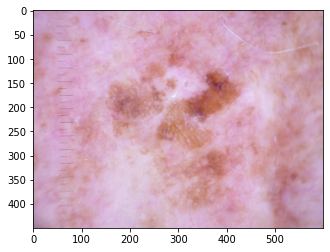

600 450


In [9]:
with Image.open(os.path.join(root, 'HAM10000_images_part_1', 'ISIC_0027419.jpg'	)) as im:
    plt.imshow(im)
    plt.show()
width, height = im.size
print(width, height)

In [10]:
batch_size = 200

In [11]:
# Define Tensorflow Dataset
print(ds_folder)
data_dir = Path(ds_folder)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(height, width),
  batch_size=200)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(height, width),
  batch_size=batch_size)

data/dataset
Found 10015 files belonging to 7 classes.
Using 8012 files for training.
Found 10015 files belonging to 7 classes.
Using 2003 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

AttributeError: ignored

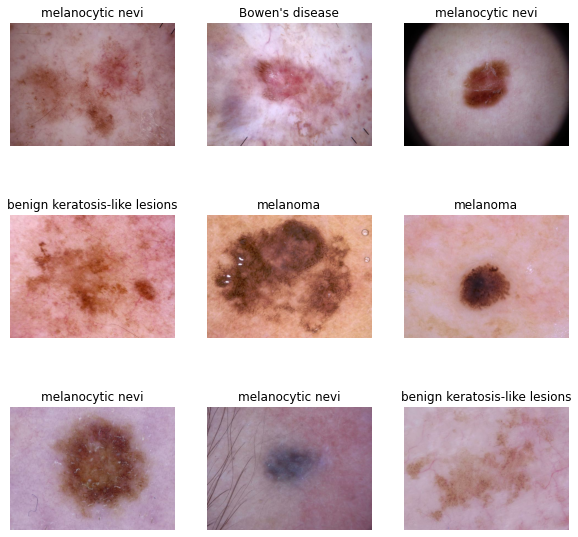

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
print('training set: ', train_ds.cardinality().numpy() * batch_size)
print('val set: ', val_ds.cardinality().numpy() * batch_size)
num_classes = len(class_names)
print('num classes: ', num_classes)

training set:  8200
val set:  2200
num classes:  7


# Build CNN

In [24]:
MyCNN = Sequential([
  layers.Rescaling(1./255, input_shape=(height, width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [25]:
MyCNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
MyCNN.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 450, 600, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 450, 600, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 225, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 225, 300, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 150, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 150, 64)      1

In [1]:
epochs=10
history = MyCNN.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: ignored